# 1-1 结构化数据建模流程范例

In [1]:
import os 
import datetime

In [2]:
# 打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s" % nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 


## 一、准备数据

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

dftrain_raw = pd.read_csv('./data/titanic/train.csv')
dftest_raw = pd.read_csv('./data/titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


字段说明： <p>
Survived:0代表死亡，1代表存活【y标签】 <p>
Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】 <p>
Name:乘客姓名 【舍去】 <p>
Sex:乘客性别 【转换成bool特征】 <p>
Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】 <p>
SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】 <p>
Parch:乘客父母/孩子的个数(整数值)【数值特征】 <p>
Ticket:票号(字符串)【舍去】 <p>
Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】 <p>
Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】 <p>
Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】 <p>

## 二、数据预处理

In [8]:
def Preprocessing(dfdata):
    dfresult = pd.DataFrame()
    
    # Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
    dfPclass = pd.get_dummies(dfdata['Pclass']) # Dataframe
    dfPclass.columns = ['Pclass_' +str(x) for x in dfPclass.columns ] 
    # dfPclass修改列名，列名默认为onehot前的值（此处为1，2，3）
    dfresult = pd.concat([dfresult, dfPclass], axis=1) 
    # dfresult 和 dfPclass拼接; axis=1，表示纵轴，即对对象做横向的操作
    
    # Sex
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult, dfSex], axis=1)
    
    # Age
    dfresult['Age'] = dfdata['Age'].fillna(0) # 用0填充Dataframe中的NaN值
    dfresult['Age_null'] = pd.isna(dfdata['Age']).astype('int32') 
    # isna 值为nan=True，返回Series；astype将True/False值
    
    # SibSp,Parch,Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']
    
    # Cabin
    dfresult['Cabin_null'] = pd.isna(dfdata['Cabin']).astype('int32')
    
    # Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'], dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult, dfEmbarked], axis=1)
    
    return(dfresult) # DataFrame


In [9]:
Preprocessing(dftrain_raw).head(5) # Preprocessing(dftrain_raw).values numpy.ndarray shape(712, 15)

,Pclass_1,Pclass_2,Pclass_3,female,male,Age,Age_null,SibSp,Parch,Fare,Cabin_null,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,1,0,0,0,1,55.0,0,0,0,30.5000,0,0,0,1,0
1,1,0,0,1,0,49.0,0,1,0,76.7292,0,1,0,0,0
2,0,1,0,1,0,36.0,0,0,0,13.0000,1,0,0,1,0
3,0,1,0,0,1,19.0,0,0,0,13.0000,1,0,0,1,0
4,0,0,1,0,1,14.0,0,4,1,39.6875,1,0,0,1,0


In [10]:
x_train = Preprocessing(dftrain_raw).values
y_train = dftrain_raw['Survived'].values

x_test = Preprocessing(dftest_raw).values
y_test = dftest_raw['Survived'].values

print("x_train.shape =", x_train.shape )
print("x_test.shape =", x_test.shape )

print("y_train.shape =", y_train.shape )
print("y_test.shape =", y_test.shape )

x_train.shape = (712, 15)
x_test.shape = (179, 15)
y_train.shape = (712,)
y_test.shape = (179,)


#### 进一步使用DataLoader和TensorDataset封装成可以迭代的数据管道。

In [11]:
dl_train = DataLoader(TensorDataset(torch.tensor(x_train).float(),torch.tensor(y_train).float()), 
                      shuffle=True, # 默认为False
                      batch_size=8, 
                      # drop_last=True, # 是否丢弃最后一个样本数量不足batch_size批次数据。这里712/8=89，正好89个batch。
                      # num_workers=2, # 使用多进程读取数据，设置的进程数。
                     )

dl_valid = DataLoader(TensorDataset(torch.tensor(x_test).float(),torch.tensor(y_test).float()), 
                      shuffle=False, 
                      batch_size=8, 
                      # num_workers=6, 
                     )

# 测试数据管道
for features,labels in dl_train:
    print(features,labels)
    break

tensor([[ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 18.0000,  0.0000,  0.0000,
          0.0000,  7.7750,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000, 13.0000,  0.0000,  0.0000,
          0.0000,  7.2292,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000, 22.0000,  0.0000,  1.0000,
          0.0000,  7.2500,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  1.0000, 42.0000,  0.0000,  0.0000,
          0.0000, 13.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  0.0000,  1.0000, 54.0000,  0.0000,  1.0000,
          0.0000, 26.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  7.2250,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0

## 三、定义模型

使用Pytorch通常有三种方式构建模型：使用nn.Sequential按层顺序构建模型，继承nn.Module基类构建自定义模型，继承nn.Module基类构建模型并辅助应用模型容器进行封装。

此处选择使用最简单的nn.Sequential，按层顺序模型。

In [47]:
def create_net():
    net = nn.Sequential()
    net.add_module("linear1", nn.Linear(15,20))
    net.add_module("relu1", nn.ReLU())
    net.add_module("linear2", nn.Linear(20,15))
    net.add_module("relu2", nn.ReLU())
    net.add_module("linear3", nn.Linear(15,1))
    net.add_module("sigmoid", nn.Sigmoid())
    
    return(net)
    
net = create_net()
print(net)


Sequential(
  (linear1): Linear(in_features=15, out_features=20, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=20, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [48]:
from torchkeras import summary
summary(net,input_shape=(15,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]             320
              ReLU-2                   [-1, 20]               0
            Linear-3                   [-1, 15]             315
              ReLU-4                   [-1, 15]               0
            Linear-5                    [-1, 1]              16
           Sigmoid-6                    [-1, 1]               0
Total params: 651
Trainable params: 651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000057
Forward/backward pass size (MB): 0.000549
Params size (MB): 0.002483
Estimated Total Size (MB): 0.003090
----------------------------------------------------------------


## 四、训练模型

Pytorch通常需要用户编写自定义训练循环，训练循环的代码风格因人而异。

有3类典型的训练循环代码风格：脚本形式训练循环，函数形式训练循环，类形式训练循环。

此处介绍一种较通用的脚本形式。

```python
from sklearn.metrics import accuracy_score
y_pred = [0, 2, 1, 3]
y_true = [0, 1, 2, 3]

print(accuracy_score(y_true, y_pred)) # 0.5
print(accuracy_score(y_true, y_pred, normalize=False)) # 2
# normalize If False, return the number of correctly classified samples. Default = True

# 多分类
print(accuracy_score(np.array([[0, 1], [1, 1]]), np.ones((2, 2)))) # 0.5
```

In [49]:
from sklearn.metrics import accuracy_score

loss_func = nn.BCELoss() # Binary Cross Entropy
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.01)
metric_func = lambda y_pred, y_true: accuracy_score(y_true.data.numpy(),y_pred.data.numpy()>0.5)
metric_name = "accuracy"

In [50]:
epochs = 10
log_step_freq = 30

dfhistory = pd.DataFrame(columns = ["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])
print("Start Training...")
printbar()


for epoch in range(1, epochs+1):
    
    # 1，训练循环-------------------------------------------------
    net.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features,labels) in enumerate(dl_train, 1): 
    # start=1, 从1开始enumerate
    # 1个step对应1个batch，共89个batch/step
        
        # 梯度清零
        optimizer.zero_grad()

        # 正向传播求损失
        predictions = net(features)
        loss = loss_func(predictions,labels)
        metric = metric_func(predictions,labels)
        
        # 反向传播求梯度
        loss.backward()
        optimizer.step()

        # 打印batch级别日志
        # log_step_freq的整数倍打印一次
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step%log_step_freq == 0:   
            print(("[step = %d] loss: %.3f, "+metric_name+": %.3f") %
                  (step, loss_sum/step, metric_sum/step))
    
    # 2，验证循环-------------------------------------------------
    net.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1

    for val_step, (features,labels) in enumerate(dl_valid, 1):
    # 23个batch, 其中22个整batch，第23个batch只有3条数据
    # 即23个val_step
    
        # 关闭梯度计算
        with torch.no_grad():
            predictions = net(features)
            val_loss = loss_func(predictions,labels)
            val_metric = metric_func(predictions,labels)
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    # 3，记录日志-------------------------------------------------
    # 共10个epoch
    info = (epoch, loss_sum/step, metric_sum/step, 
            val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印epoch级别日志
    print(("\nEPOCH = %d, loss = %.3f,"+ metric_name + \
          "  = %.3f, val_loss = %.3f, "+"val_"+ metric_name+" = %.3f") 
          %info)
    printbar()
    
    
print('Finished Training...')

Start Training...

================================================================================2020-10-10 19:53:20
[step = 30] loss: 0.707, accuracy: 0.608
[step = 60] loss: 0.675, accuracy: 0.615

EPOCH = 1, loss = 0.658,accuracy  = 0.604, val_loss = 0.576, val_accuracy = 0.649

================================================================================2020-10-10 19:53:20
[step = 30] loss: 0.611, accuracy: 0.642
[step = 60] loss: 0.597, accuracy: 0.669

EPOCH = 2, loss = 0.583,accuracy  = 0.697, val_loss = 0.503, val_accuracy = 0.750

================================================================================2020-10-10 19:53:20
[step = 30] loss: 0.567, accuracy: 0.729
[step = 60] loss: 0.547, accuracy: 0.746

EPOCH = 3, loss = 0.537,accuracy  = 0.758, val_loss = 0.475, val_accuracy = 0.783

================================================================================2020-10-10 19:53:20
[step = 30] loss: 0.540, accuracy: 0.771
[step = 60] loss: 0.503, accuracy: 0.800



## 五、评估模型

In [51]:
# 我们首先评估一下模型在训练集和验证集上的效果。
dfhistory

,epoch,loss,accuracy,val_loss,val_accuracy
0,1.0,0.657803,0.603933,0.576202,0.648551
1,2.0,0.583431,0.696629,0.503376,0.750000
2,3.0,0.536627,0.758427,0.474669,0.782609
3,4.0,0.513675,0.778090,0.462244,0.760870
4,5.0,0.509182,0.790730,0.458934,0.793478
5,6.0,0.516911,0.755618,0.429230,0.793478
6,7.0,0.488550,0.800562,0.486030,0.804348
7,8.0,0.482085,0.776685,0.441671,0.820652
8,9.0,0.497420,0.785112,0.436222,0.815217
9,10.0,0.473244,0.808989,0.434314,0.809783


In [52]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['train_'+metric, 'val_'+metric])
    plt.show()

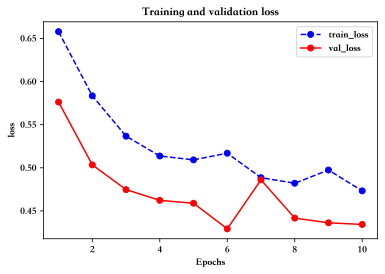

In [53]:
plot_metric(dfhistory, "loss") 

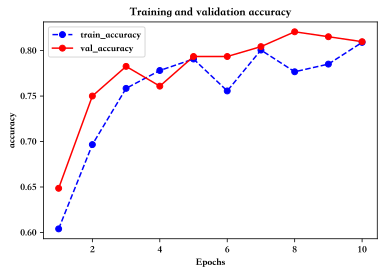

In [54]:
plot_metric(dfhistory,"accuracy")

## 六、使用模型

In [55]:
dftest_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.5500,NaN,S
1,405,0,3,"Oreskovic, Miss. Marija",female,20.00,0,0,315096,8.6625,NaN,S
2,635,0,3,"Skoog, Miss. Mabel",female,9.00,3,2,347088,27.9000,NaN,S
3,701,1,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18.00,1,0,PC 17757,227.5250,C62 C64,C
4,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
5,400,1,2,"Trout, Mrs. William H (Jessie L)",female,28.00,0,0,240929,12.6500,NaN,S
6,481,0,3,"Goodwin, Master. Harold Victor",male,9.00,5,2,CA 2144,46.9000,NaN,S
7,44,1,2,"Laroche, Miss. Simonne Marie Anne Andree",female,3.00,1,2,SC/Paris 2123,41.5792,NaN,C
8,446,1,1,"Dodge, Master. Washington",male,4.00,0,2,33638,81.8583,A34,S
9,811,0,3,"Alexander, Mr. William",male,26.00,0,0,3474,7.8875,NaN,S


In [56]:
#预测概率
y_pred_probs = net(torch.tensor(x_test[0:10]).float()).data
print(y_pred_probs)

#预测类别
y_pred = torch.where(y_pred_probs>0.5,
        torch.ones_like(y_pred_probs),torch.zeros_like(y_pred_probs))
print(y_pred)

tensor([[0.0703],
        [0.5997],
        [0.3697],
        [0.7750],
        [0.6104],
        [0.7701],
        [0.0622],
        [0.7750],
        [0.7084],
        [0.1080]])
tensor([[0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])


## 七、保存模型
Pytorch 有两种保存模型的方式，都是通过调用pickle序列化方法实现的。

第一种方法只保存模型参数。

第二种方法保存完整模型。

推荐使用第一种，第二种方法可能在切换设备和目录的时候出现各种问题。

In [57]:
# 保存模型参数

print(net.state_dict().keys())

torch.save(net.state_dict(), "./result/1-1/net_parameter.pkl")

net_clone = create_net()
net_clone.load_state_dict(torch.load("./result/1-1/net_parameter.pkl"))

net_clone.forward(torch.tensor(x_test[0:10]).float()).data

odict_keys(['linear1.weight', 'linear1.bias', 'linear2.weight', 'linear2.bias', 'linear3.weight', 'linear3.bias'])


tensor([[0.0703],
        [0.5997],
        [0.3697],
        [0.7750],
        [0.6104],
        [0.7701],
        [0.0622],
        [0.7750],
        [0.7084],
        [0.1080]])

In [58]:
# 保存完整模型(不推荐)

torch.save(net, './result/1-1/net_model.pkl')
net_loaded = torch.load('./result/1-1/net_model.pkl')
net_loaded(torch.tensor(x_test[0:10]).float()).data

tensor([[0.0703],
        [0.5997],
        [0.3697],
        [0.7750],
        [0.6104],
        [0.7701],
        [0.0622],
        [0.7750],
        [0.7084],
        [0.1080]])